In [1]:
import torch 
from torch import nn
from torch.nn import init
import torch.utils.data as data_utils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import heapq

In [2]:
dataset = np.loadtxt('../ml-1m/ratings.dat', delimiter='::', usecols=[0,1,3], dtype=int)
#dataset = np.loadtxt('../Yelp/yelp.rating', usecols=[0,1,3], dtype=int)

number of items:  3952
number of flows:  1000209
avg of S(x):  253.0
parameter phi:  0.00025
parameter epsilon should less than or equal phi
sketch belongs to half of the stream
phi = 0.00025
S = 1000209
r = 4
w = 1000


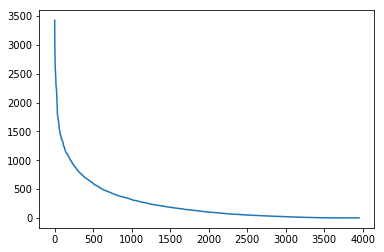

In [3]:
def veiwData(dataset):
    n_users  = np.max(dataset[:,0])
    n_items  = np.max(dataset[:,1])
    avgS     = round(len(dataset) / n_items, 0)
    itemFreq = [0 for x in range(n_items)]
    for record in dataset:
        itemFreq[record[1]-1] += 1
    realHH = set()
    for i,n in enumerate(itemFreq):
        if n >= avgS:
            realHH.add(i+1)
    itemFreq.sort(reverse=True)
    plt.plot(range(len(itemFreq)), itemFreq)
    print("number of items: ", n_items)
    print("number of flows: ", len(dataset))
    print("avg of S(x): ", avgS)
    print("parameter phi: ", round(1 / n_items, 5))
    print("parameter epsilon should less than or equal phi")
    print("sketch belongs to half of the stream")
    return realHH, round(1 / n_items, 5), dataset.shape[0]

realHH, phi, S = veiwData(dataset)
print("phi =", phi)
print("S =", S)
delta   = 0.05
epsilon = 0.002
r = round(np.log2(1 / delta)).astype(np.int)
w = round(2 / epsilon)
print("r =", r)
print("w =", w)

In [4]:
class HHtracer():
    def __init__(self, sketch_width, sketch_deep):
        self.sketch_width = sketch_width
        self.sketch_deep  = sketch_deep 
        self.sketch = [[(0,0,0) for x in range(sketch_width)] for y in range(sketch_deep)]
        return
    
    def processStream_HH(self, dataset):
        for record in dataset:
            item = (record[1], 1)
            self.update(item)
        return
    
    def update(self, item):
        x  = item[0]
        vx = item[1]
        for i in range(self.sketch_deep):
            np.random.seed(i + x)
            j = np.random.choice(self.sketch_width)
            V = self.sketch[i][j][0] + vx
            K = self.sketch[i][j][1]
            C = self.sketch[i][j][2]
            if K == x:
                C += vx
            else:
                C -= vx
                if C < 0:
                    K = x
                    C = -C
            self.sketch[i][j] = (V, K, C)
        return
    
    def queryU(self, x):
        res_list = list()
        for i in range(self.sketch_deep):
            np.random.seed(i + x)
            j = np.random.choice(self.sketch_width)
            V = self.sketch[i][j][0]
            K = self.sketch[i][j][1]
            C = self.sketch[i][j][2] 
            if K == x:
                S = (V + C) / 2
            else:
                S = (V - C) / 2
            res_list.append(S)
        return min(res_list)   
    
    def hitter(self, phi, S):
        print("heavy hitter threshold: ", phi * S)
        hh = dict()
        for i in range(self.sketch_deep):
            for j in range(self.sketch_width):
                if self.sketch[i][j][0] >= phi * S:
                    x = self.sketch[i][j][1]
                    freq = self.queryU(x)
                    if freq >= phi * S:
                        if x not in hh.keys() or (x in hh.keys() and hh[x] < freq):
                            hh[x] = freq
        return hh
    
    def getHH(self, dataset, phi, S):
        self.processStream_HH(dataset)
        hh = self.hitter(phi, S)
        return hh
    
    def evaluate(self, res, real):
        tp = fp = fn = 0
        for i in res:
            if i in real:
                tp += 1
            else:
                fp += 1
        for j in real:
            if j not in res:
                fn += 1
        print("TP =",tp,"   FP =", fp,"   FN =", fn)
        recall = tp / (tp + fn)
        print('reacall:', recall)
        precision = tp / (tp + fp)
        print('precision:',precision)
        f1 = (2 * recall * precision) / (precision + recall)
        print('F1-score:',f1)
        return

In [5]:
data = dataset[dataset[:,2].argsort()]  # (user,item,tiemstamp, ...)
hh_tracer = HHtracer(w, r)
hhDict = hh_tracer.getHH(data, phi, S)
resHH = set(hhDict.keys())
hh_tracer.evaluate(resHH, realHH)

heavy hitter threshold:  250.05225000000002
TP = 1115    FP = 45    FN = 91
reacall: 0.9245439469320066
precision: 0.9612068965517241
F1-score: 0.9425190194420964


In [6]:
N_USER = np.max(dataset[:,0])
N_ITEM = np.max(dataset[:,1])
EMB_SIZE = 64
NEG_WEIGHT = 0
DROP_RATIO = 0.3
LEARNING_RATE = 0.005
BATCH_SIZE = 128
EPOCH = 200

In [7]:
def generate_train_from_local(path, n_user, n_item):
    data = np.loadtxt(fname=path, delimiter="\t", skiprows=1, dtype=int)
    train_matrix = np.zeros((n_user, n_item), dtype = np.int8)
    for line in data:
        train_matrix[line[0],line[1]] = 1
    user_pos = dict()
    max_item_id = train_matrix.shape[1]
    max_item_num = 0
    for u, i in enumerate(train_matrix):
        pos_item = list(np.nonzero(i)[0])
        pos_item_num = len(pos_item)
        if  pos_item_num > max_item_num:
            max_item_num = pos_item_num
        user_pos[u] = pos_item
    train_user = list()
    train_item = list()
    for k in user_pos.keys():
        while len(user_pos[k]) < max_item_num:
            user_pos[k].append(max_item_id)
        train_user.append(k)
        train_item.append(user_pos[k])
    return np.array(train_user), np.array(train_item), train_matrix

def generate_test_from_local(path):
    data = np.loadtxt(fname=path, delimiter="\t", skiprows=1, dtype=int)
    return data

train_user, train_item, train_matrix = generate_train_from_local(path="../ml-1m/ml.train.txt",n_user=N_USER,n_item=N_ITEM)
test = generate_test_from_local(path="../ml-1m/ml.test.txt")

In [8]:
torch_x1 = torch.from_numpy(train_user).type(torch.LongTensor)
torch_x2 = torch.from_numpy(train_item).type(torch.LongTensor)
torch_test = torch.from_numpy(test).type(torch.LongTensor)
torch_dataset = data_utils.TensorDataset(torch_x1, torch_x2)
train_loader = data_utils.DataLoader(dataset = torch_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)
torch_testset = data_utils.TensorDataset(torch_test[:,0],torch_test[:,1])
test_loader = data_utils.DataLoader(dataset = torch_testset, batch_size = BATCH_SIZE, num_workers = 0)

In [9]:
class ENMF(nn.Module):
    def __init__(self, emb_size, n_user, n_item, neg_weight, drop_out, count, c0=512, x=0.6):
        super().__init__()
        self.c0 = c0
        self.x  = x
        self.count = count
        self.n_user = n_user
        self.n_item = n_item
        self.neg_weight = neg_weight
        self.emb_size   = emb_size
        self.user_embs = nn.Embedding(n_user, emb_size)
        self.item_embs = nn.Embedding(n_item+1, emb_size)
        self.h = nn.Parameter(torch.randn(emb_size, 1))
        self.dropout = nn.Dropout(p=drop_out)
        self.freq = self.calcu_freq()
        self._reset_para()
        return
    
    def _reset_para(self):
        nn.init.xavier_normal_(self.user_embs.weight)
        nn.init.xavier_normal_(self.item_embs.weight)
        nn.init.constant_(self.h, 0.01)
        return
    
    def calcu_freq(self):
        freq_items = sorted(self.count.keys())
        freq_count = [self.count[k] for k in freq_items]
        freq = np.zeros(self.item_embs.weight.shape[0])
        freq[freq_items] = freq_count       
        #freq = freq/np.sum(freq)
        freq = np.power(freq, self.x)
        freq = self.c0 * freq/np.sum(freq)
        freq = torch.from_numpy(freq).type(torch.float).cuda()
        return freq
    
    def forward(self, users, items):
        '''
        u_emb = self.dropout(self.user_embs(users))
        i_emb = self.item_embs(items)
        mask = (~(items.eq(self.n_item+1))).float()
        i_emb = i_emb * mask.unsqueeze(2)
        temp = list()
        for u,v in enumerate(u_emb):
            temp.append(torch.mul(v,i_emb[u]))
        pq = torch.stack(temp)
        hpq = torch.bmm(pq, torch.repeat_interleave(self.h.unsqueeze(0), repeats=pq.shape[0], dim=0)).squeeze(2)
        loss_pos = torch.sum((1 - self.neg_weight) * hpq.square() - 2.0 * hpq)
        part1 = torch.mm(self.h, self.h.T)
        part2 = torch.sum(torch.mm(u_emb.T,u_emb),0)
        part3 = torch.sum(torch.mm(self.item_embs.weight.T,self.item_embs.weight),0)
        #part3 = torch.sum(torch.bmm(i_emb.reshape(i_emb.shape[0],i_emb.shape[2],i_emb.shape[1]), i_emb),0)
        #print(part1.shape)
        #print(part2.shape)
        #print(part3.shape)
        loss_all_data = torch.sum(part1 * part2 * part3)
        loss = loss_pos + self.neg_weight * loss_all_data
        '''
        pos_freq = self.freq[items]
        u_emb = self.dropout(self.user_embs(users))
        pos_embs = self.item_embs(items)
        # torch.einsum("ab,abc->abc")
        # B * L * D
        mask = (~(items.eq(self.n_item+1))).float()
        pos_embs = pos_embs * mask.unsqueeze(2)
        # torch.einsum("ac,abc->abc")
        # B * L * D
        pq = u_emb.unsqueeze(1) * pos_embs
        # torch.einsum("ajk,kl->ajl")
        # B * L
        hpq = pq.matmul(self.h).squeeze(2)
        # loss
        pos_data_loss = torch.sum((1 - pos_freq) * hpq.square() - 2.0 * hpq)
        # torch.einsum("ab,ac->abc")
        #part_1 = self.item_embs.weight.unsqueeze(2).bmm(self.item_embs.weight.unsqueeze(1))
        part_1 = self.freq.unsqueeze(1) * self.item_embs.weight
        part_1 = part_1.unsqueeze(2).bmm(self.item_embs.weight.unsqueeze(1))
        part_2 = u_emb.unsqueeze(2).bmm(u_emb.unsqueeze(1))
        # D * D
        part_1 = part_1.sum(0)
        part_2 = part_2.sum(0)
        part_3 = self.h.mm(self.h.t())
        all_data_loss = torch.sum(part_1 * part_2 * part_3)
        #loss = self.neg_weight * all_data_loss + pos_data_loss
        loss = all_data_loss + pos_data_loss
        return loss
    
    def rank(self, uid):
        '''
        uid: Batch_size
        '''
        uid_embs = self.user_embs(uid)
        user_all_items = uid_embs.unsqueeze(1) * self.item_embs.weight
        items_score = user_all_items.matmul(self.h).squeeze(2)
        return items_score

In [10]:
model = ENMF(emb_size=EMB_SIZE, n_user=N_USER, n_item=N_ITEM, neg_weight=NEG_WEIGHT, drop_out = DROP_RATIO, count=hhDict)
if(torch.cuda.is_available()):
    model = model.cuda()
optimizer = torch.optim.Adagrad(model.parameters(), lr = LEARNING_RATE, weight_decay = 1e-3)
print(model)

ENMF(
  (user_embs): Embedding(6040, 64)
  (item_embs): Embedding(3953, 64)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [11]:
def getHitRatio(ranklist, gtItem):
    #HR击中率，如果topk中有正例ID即认为正确
    if gtItem in ranklist:
        return 1
    return 0

def getNDCG(ranklist, gtItem):
    #NDCG归一化折损累计增益
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return np.log(2) / np.log(i+2)
    return 0

def getH(ranklist1, ranklist2):
    L = len(ranklist1)
    common = len(list(set(ranklist1).intersection(set(ranklist2))))
    return 1-common/L

In [12]:
def movieEval_1(model, test_loader, train_matrix, topK = 100):
    n_users = train_matrix.shape[0]
    hit_list = list()
    undcg_list = list()
    rank_all_users = list()
    model.eval()
    with torch.no_grad(): 
        for step, (batch_x, batch_y) in enumerate(test_loader):
            if torch.cuda.is_available():
                batch_x = batch_x.cuda()  
            prediction = model.rank(batch_x)
            pred_vector = -1 * (prediction.cpu().data.numpy())
            ranklist = np.argsort(pred_vector)
            for j, r in enumerate(ranklist):
                real_r = list()
                u = batch_x[j].cpu().data.numpy()
                i = 0
                while len(real_r) < topK:
                    if r[i]==train_matrix.shape[1]:
                        i += 1
                        continue
                    if train_matrix[u][r[i]] == 0:
                        real_r.append(r[i])
                    i += 1     
                rank_all_users.append(real_r)
                pos_item = batch_y[j].cpu().data.numpy()
                hit_list.append(getHitRatio(real_r, pos_item))
                undcg_list.append(getNDCG(real_r, pos_item))
    model.train()
    hr = np.mean(hit_list)
    ndcg = np.mean(undcg_list)
    print('HR@', topK, ' = %.4f' %  hr)
    print('NDCG@', topK, ' = %.4f' % ndcg)
    return hr, ndcg, rank_all_users

In [ ]:
train_loss_list = list()
hr_list = list()
ndcg_list = list()
model.train()
for e in range(EPOCH):
    train_loss = list()
    for step, (batch_x1, batch_x2) in enumerate(train_loader):
        x1, x2 = batch_x1, batch_x2
        if (torch.cuda.is_available()):
            x1, x2 = x1.cuda(), x2.cuda()
        optimizer.zero_grad()
        loss = model(x1, x2)
        loss.backward()        
        train_loss.append(loss.cpu().item())
        optimizer.step()
    print('------第'+str(e+1)+'个epoch------')
    mean_train_loss = np.mean(train_loss)
    print('train_loss:', mean_train_loss)
    train_loss_list.append(mean_train_loss)    
    hr, ndcg, rank_all_users = movieEval_1(model, test_loader, train_matrix)
    hr_list.append(hr)
    ndcg_list.append(ndcg)

------第1个epoch------
train_loss: 0.1328761292679701
HR@ 100  = 0.0434
NDCG@ 100  = 0.0089
------第2个epoch------
train_loss: -449.371448079745
HR@ 100  = 0.1856
NDCG@ 100  = 0.0424
------第3个epoch------
train_loss: -3587.0249837239585
HR@ 100  = 0.1987
NDCG@ 100  = 0.0463
------第4个epoch------
train_loss: -10291.048014322916
HR@ 100  = 0.2030
NDCG@ 100  = 0.0477
------第5个epoch------
train_loss: -20371.781992594402
HR@ 100  = 0.2070
NDCG@ 100  = 0.0491
------第6个epoch------
train_loss: -33172.92337036133
HR@ 100  = 0.2108
NDCG@ 100  = 0.0508
------第7个epoch------
train_loss: -48385.316162109375
HR@ 100  = 0.2129
NDCG@ 100  = 0.0518
------第8个epoch------
train_loss: -65780.4321899414
HR@ 100  = 0.2088
NDCG@ 100  = 0.0514
------第9个epoch------
train_loss: -84310.98274739583
HR@ 100  = 0.1975
NDCG@ 100  = 0.0502
------第10个epoch------
train_loss: -103798.64213053386
HR@ 100  = 0.1922
NDCG@ 100  = 0.0505
------第11个epoch------
train_loss: -124142.79577636719
HR@ 100  = 0.1937
NDCG@ 100  = 0.0512
----